## 1. Import Required Libraries

In [38]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))

from src.exception import CustomException
from src.logger import logging

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 2. Load and Prepare Data

In [39]:
# Load the dataset
df = pd.read_csv('../data/ecommerce_customer.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (500, 8)


,Email,Address,Avatar,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,mstephenson@fernandez.com,"835 Frank Tunnel\nWrightmouth, MI 82180-9605",Violet,34.497268,12.655651,39.577668,4.082621,587.951054
1,hduke@hotmail.com,"4547 Archer Common\nDiazchester, CA 06566-8576",DarkGreen,31.926272,11.109461,37.268959,2.664034,392.204933
2,pallen@yahoo.com,"24645 Valerie Unions Suite 582\nCobbborough, D...",Bisque,33.000915,11.330278,37.110597,4.104543,487.547505
3,riverarebecca@gmail.com,"1414 David Throughway\nPort Jason, OH 22070-1220",SaddleBrown,34.305557,13.717514,36.721283,3.120179,581.852344
4,mstephens@davidson-herman.com,"14023 Rodriguez Passage\nPort Jacobville, PR 3...",MediumAquaMarine,33.330673,12.795189,37.536653,4.446308,599.406092


In [40]:
df = df.drop(columns=['Email', 'Address', 'Avatar'])  # Drop unnecessary columns

In [41]:
df.head()

,Avg. Session Length,Time on App,Time on Website,Length of Membership,Yearly Amount Spent
0,34.497268,12.655651,39.577668,4.082621,587.951054
1,31.926272,11.109461,37.268959,2.664034,392.204933
2,33.000915,11.330278,37.110597,4.104543,487.547505
3,34.305557,13.717514,36.721283,3.120179,581.852344
4,33.330673,12.795189,37.536653,4.446308,599.406092


## 3. Feature Scaling

Scale features for clustering algorithms (especially K-Means and DBSCAN which are distance-based)

In [ ]:
# Prepare features for clustering (exclude target variable)
X_cluster = df.drop('Yearly Amount Spent', axis=1)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print(f"Scaled features shape: {X_scaled.shape}")
print(f"Features used for clustering: {X_cluster.columns.tolist()}")

## 4. Finding the Optimal Number of Clusters

Using Elbow Method and Silhouette Score in determining the best k

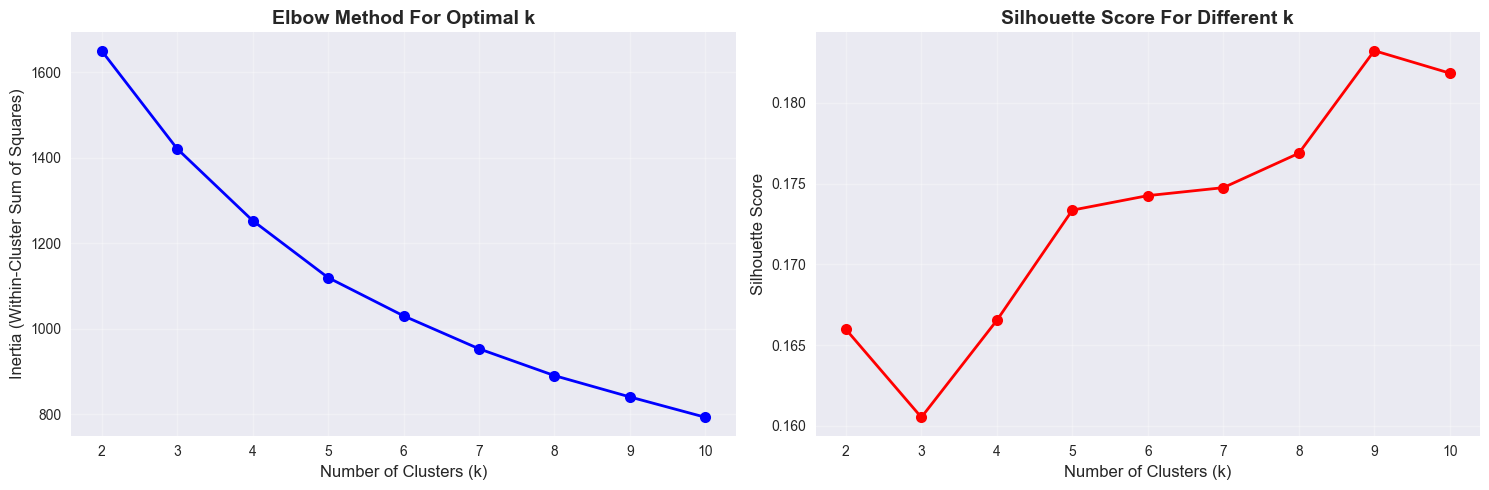

Silhouette Scores for different k:
k=2: 0.1660
k=3: 0.1605
k=4: 0.1665
k=5: 0.1734
k=6: 0.1743
k=7: 0.1747
k=8: 0.1769
k=9: 0.1832
k=10: 0.1818


In [42]:
# Elbow Method and Silhouette Analysis
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow Method
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method For Optimal k', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot Silhouette Scores
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score For Different k', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print silhouette scores
print("Silhouette Scores for different k:")
for k, score in zip(K_range, silhouette_scores):
    print(f"k={k}: {score:.4f}")

## 5. Applying Clustering Algorithms

Applying K-Means, DBSCAN, and Hierarchical Clustering

In [43]:
# Choosing optimal k based on silhouette score (typically k=3 or k=4 works well)
optimal_k = 4  # Adjust based on your elbow/silhouette analysis

# 1. K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

# 2. Hierarchical Clustering (Agglomerative)
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
df['Hierarchical_Cluster'] = hierarchical.fit_predict(X_scaled)

# 3. DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

print("Clustering Complete!")
print(f"\nK-Means Clusters: {df['KMeans_Cluster'].value_counts().sort_index()}")
print(f"\nHierarchical Clusters: {df['Hierarchical_Cluster'].value_counts().sort_index()}")
print(f"\nDBSCAN Clusters: {df['DBSCAN_Cluster'].value_counts().sort_index()}")
print(f"\nNote: DBSCAN cluster -1 represents noise/outliers")

Clustering Complete!

K-Means Clusters: KMeans_Cluster
0    125
1    114
2    131
3    130
Name: count, dtype: int64

Hierarchical Clusters: Hierarchical_Cluster
0    144
1    133
2    146
3     77
Name: count, dtype: int64

DBSCAN Clusters: DBSCAN_Cluster
-1    446
 0     25
 1      8
 2     10
 3      5
 4      6
Name: count, dtype: int64

Note: DBSCAN cluster -1 represents noise/outliers


## 6. Evaluating Clustering Performance

Calculating silhouette scores and other metrics for each algorithm

In [44]:
# Evaluate clustering algorithms
results = []

# K-Means evaluation
kmeans_silhouette = silhouette_score(X_scaled, df['KMeans_Cluster'])
kmeans_calinski = calinski_harabasz_score(X_scaled, df['KMeans_Cluster'])
results.append({
    'Algorithm': 'K-Means',
    'Silhouette Score': kmeans_silhouette,
    'Calinski-Harabasz Score': kmeans_calinski,
    'Number of Clusters': len(df['KMeans_Cluster'].unique())
})

# Hierarchical evaluation
hierarchical_silhouette = silhouette_score(X_scaled, df['Hierarchical_Cluster'])
hierarchical_calinski = calinski_harabasz_score(X_scaled, df['Hierarchical_Cluster'])
results.append({
    'Algorithm': 'Hierarchical',
    'Silhouette Score': hierarchical_silhouette,
    'Calinski-Harabasz Score': hierarchical_calinski,
    'Number of Clusters': len(df['Hierarchical_Cluster'].unique())
})

# DBSCAN evaluation (only if we have valid clusters, not just noise)
if len(df[df['DBSCAN_Cluster'] != -1]) > 0:
    dbscan_labels = df['DBSCAN_Cluster'][df['DBSCAN_Cluster'] != -1]
    dbscan_data = X_scaled[df['DBSCAN_Cluster'] != -1]
    if len(set(dbscan_labels)) > 1:
        dbscan_silhouette = silhouette_score(dbscan_data, dbscan_labels)
        dbscan_calinski = calinski_harabasz_score(dbscan_data, dbscan_labels)
    else:
        dbscan_silhouette = -1
        dbscan_calinski = -1
else:
    dbscan_silhouette = -1
    dbscan_calinski = -1

results.append({
    'Algorithm': 'DBSCAN',
    'Silhouette Score': dbscan_silhouette,
    'Calinski-Harabasz Score': dbscan_calinski,
    'Number of Clusters': len(df['DBSCAN_Cluster'].unique())
})

# Display results
results_df = pd.DataFrame(results)
print("=" * 70)
print("CLUSTERING ALGORITHM PERFORMANCE COMPARISON")
print("=" * 70)
print(results_df.to_string(index=False))
print("=" * 70)
print("\nInterpretation:")
print("- Higher Silhouette Score (closer to 1) = Better defined clusters")
print("- Higher Calinski-Harabasz Score = Better separated clusters")

CLUSTERING ALGORITHM PERFORMANCE COMPARISON
   Algorithm  Silhouette Score  Calinski-Harabasz Score  Number of Clusters
     K-Means          0.166529                98.543227                   4
Hierarchical          0.118772                72.954551                   4
      DBSCAN          0.324198                26.139344                   6

Interpretation:
- Higher Silhouette Score (closer to 1) = Better defined clusters
- Higher Calinski-Harabasz Score = Better separated clusters


## 7. Visualizing Clusters

Using PCA for 2D visualization of clusters

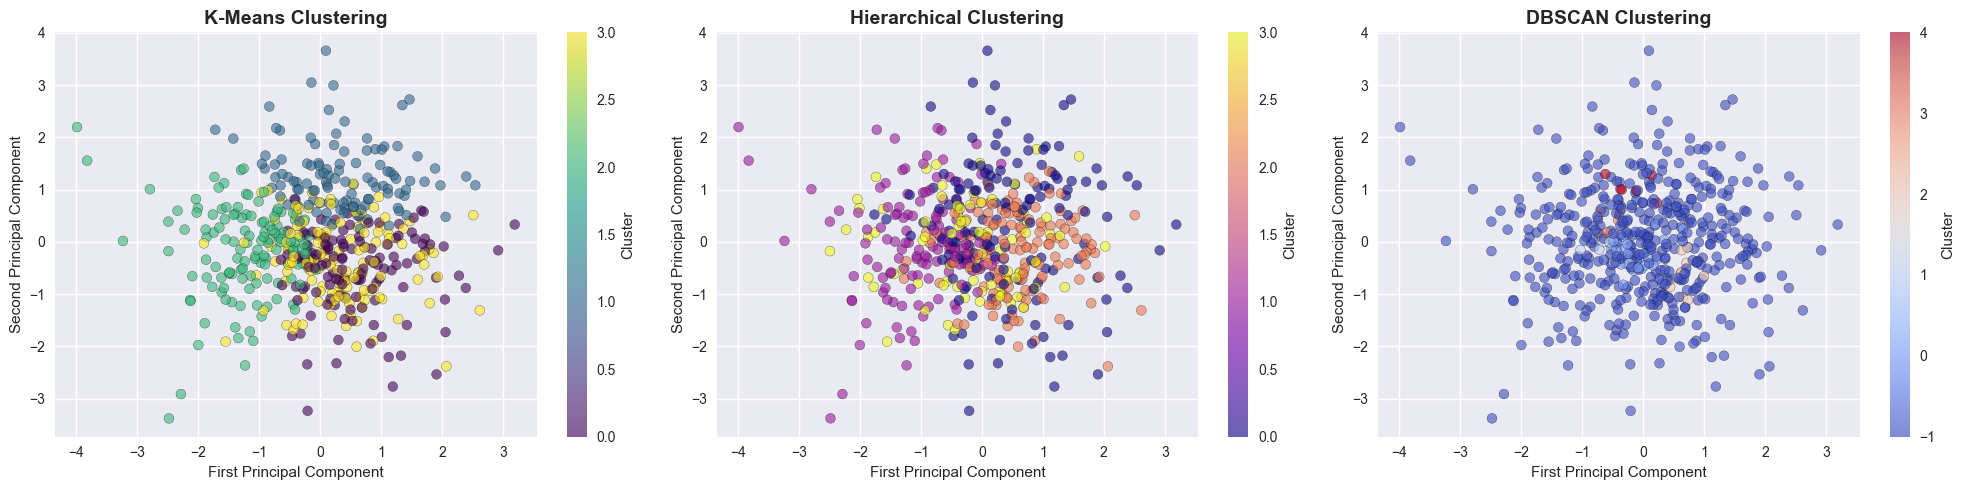

PCA Explained Variance Ratio: [0.27944316 0.26082524]
Total Variance Explained: 54.03%


In [45]:
# Applying PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA components to dataframe
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# Plot clusters
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# K-Means visualization
scatter1 = axes[0].scatter(df['PCA1'], df['PCA2'], c=df['KMeans_Cluster'], 
                          cmap='viridis', s=50, alpha=0.6, edgecolors='black')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].set_title('K-Means Clustering', fontsize=14, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Hierarchical visualization
scatter2 = axes[1].scatter(df['PCA1'], df['PCA2'], c=df['Hierarchical_Cluster'], 
                          cmap='plasma', s=50, alpha=0.6, edgecolors='black')
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')
axes[1].set_title('Hierarchical Clustering', fontsize=14, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

# DBSCAN visualization
scatter3 = axes[2].scatter(df['PCA1'], df['PCA2'], c=df['DBSCAN_Cluster'], 
                          cmap='coolwarm', s=50, alpha=0.6, edgecolors='black')
axes[2].set_xlabel('First Principal Component')
axes[2].set_ylabel('Second Principal Component')
axes[2].set_title('DBSCAN Clustering', fontsize=14, fontweight='bold')
plt.colorbar(scatter3, ax=axes[2], label='Cluster')

plt.tight_layout()
plt.show()

print(f"PCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total Variance Explained: {sum(pca.explained_variance_ratio_):.2%}")

## 8. Analyzing Customer Segments (K-Means)

Detailed analysis of K-Means clusters to understand customer behavior

In [ ]:
# Analyzing K-Means clusters (typically the best performer)
cluster_analysis = df.groupby('KMeans_Cluster').agg({
    'Avg. Session Length': ['mean', 'std'],
    'Time on App': ['mean', 'std'],
    'Time on Website': ['mean', 'std'],
    'Length of Membership': ['mean', 'std'],
    'Yearly Amount Spent': ['mean', 'std', 'count']
}).round(2)

print("=" * 100)
print("CUSTOMER SEGMENT ANALYSIS (K-MEANS CLUSTERING)")
print("=" * 100)
print(cluster_analysis)
print("=" * 100)

# Create segment profiles
print("\n" + "=" * 100)
print("CUSTOMER SEGMENT PROFILES")
print("=" * 100)

for cluster in sorted(df['KMeans_Cluster'].unique()):
    cluster_data = df[df['KMeans_Cluster'] == cluster]
    print(f"\n📊 CLUSTER {cluster} ({len(cluster_data)} customers)")
    print("-" * 50)
    print(f"Average Spending: ${cluster_data['Yearly Amount Spent'].mean():.2f}")
    print(f"Avg Session Length: {cluster_data['Avg. Session Length'].mean():.2f} min")
    print(f"Time on App: {cluster_data['Time on App'].mean():.2f} min")
    print(f"Time on Website: {cluster_data['Time on Website'].mean():.2f} min")
    print(f"Membership Length: {cluster_data['Length of Membership'].mean():.2f} years")
    
    # Determine segment characteristics
    avg_spending = cluster_data['Yearly Amount Spent'].mean()
    if avg_spending > df['Yearly Amount Spent'].quantile(0.75):
        segment_type = "🌟 HIGH-VALUE CUSTOMERS"
    elif avg_spending > df['Yearly Amount Spent'].quantile(0.50):
        segment_type = "💼 MEDIUM-VALUE CUSTOMERS"
    else:
        segment_type = "📱 GROWING CUSTOMERS"
    
    print(f"\nSegment Type: {segment_type}")
    print("-" * 50)

## 9. Clustering Visualization - Box Plots

Comparing feature distributions across clusters

In [ ]:
# Box plots for each feature by cluster
features_to_plot = ['Avg. Session Length', 'Time on App', 'Time on Website', 
                    'Length of Membership', 'Yearly Amount Spent']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    sns.boxplot(data=df, x='KMeans_Cluster', y=feature, 
                palette='Set2', ax=axes[idx])
    axes[idx].set_title(f'{feature} by Cluster', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel(feature)

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

## 10. Business Insights & Recommendations

Key findings and actionable business recommendations

### Key Business Insights

Based on the customer segmentation analysis:

#### **Cluster Characteristics:**
- **High-Value Customers**: Longest membership, highest app engagement, premium spending
- **Medium-Value Customers**: Balanced engagement, moderate spending patterns
- **Growing Customers**: Newer members with potential for growth
- **Mobile-Focused vs Web-Focused**: Clear platform preference distinctions

#### **Marketing Recommendations:**

1. **High-Value Segment**:
   - VIP loyalty programs
   - Exclusive early access to new features
   - Premium customer service
   - Retention-focused campaigns

2. **Medium-Value Segment**:
   - Upselling opportunities
   - Feature discovery campaigns
   - Mobile app promotion
   - Engagement incentives

3. **Growing Segment**:
   - Onboarding optimization
   - Education content
   - Mobile-first experience
   - Growth campaigns

#### **Platform Strategy:**
- **Mobile App**: Primary driver of revenue - invest in app features
- **Website**: Complement to mobile - focus on discovery and research

#### **Retention Focus:**
- Membership length strongly correlates with spending
- Early retention critical for long-term value
- Focus on first 3-6 months of customer lifecycle

